In [1]:
from nltk import data
from nltk.corpus.reader import CHILDESCorpusReader
from nltk.probability import FreqDist
import entropies7.entropies7 as Ent
from numpy import *
import scipy as sp
import numpy as np
import re
import os as os

%matplotlib inline
from pandas import *
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


In [47]:
def get_files(corpus):
    if corpus =='childes':
        corpus_root = data.find('corpora/childes/English-UK-MOR')
        eng = CHILDESCorpusReader(corpus_root, 'Manchester/.*.xml')
        if(corpus_root == "/Users/dspoka/nltk_data/corpora/childes/English-UK-MOR"):
            data_directory = "/Users/dspoka/Desktop/moscoso/nltk_childes/NLTKCHILDES/"
        else:
            data_directory = "/Users/jeremyirvin/Desktop/SeniorThesis/Childes/nltk_childes/NLTKCHILDES/"
        files = eng.fileids()
    return corpus_root, eng, files, data_directory
# %timeit files = get_files('childes')
corpus_root, eng, files, data_directory = get_files('childes')
nmmfile = data_directory + "morph-eng.csv"
nmsfile = data_directory + "syntax-eng.csv"
# childes has 804 files

In [3]:
def convert_age_to_days(age):
    parsed_age = re.split('P|Y|M|D',age)
    years = parsed_age[1]
    months = parsed_age[2]
    days = parsed_age[3]
    if days == '':
        days = 0
    return int(years)*365+int(months)*30+int(days)

In [4]:
def compare(f1, f2):
    age1 = convert_age_to_days(eng.age(f1)[0])
    age2 = convert_age_to_days(eng.age(f2)[0])
    if age1 < age2:
        return -1
    elif age2 < age1:
        return 1
    else:
        return 0
   
def group_files_by_child_age(files):
    # Group files by age, child, and corpus
    resDict = {}
    for f in files:
        child = f.split("/")[1]
        if resDict.has_key(child):
            resDict[child] += [f]
        else:
            resDict[child] = [f]
    for child in resDict.keys():
        resDict[child] = sorted(resDict[child], cmp=compare)
    
    return resDict

# %timeit resDict = group_files_by_child_age(files)
resDict = group_files_by_child_age(files)

In [70]:
def write_list_to_file(f, file_path, use_stem, speaker):
    fout = open(file_path, "w")
    if(use_stem == False):
        words = eng.words(f,speaker=speaker,replace=True)
    else:
        words = [w.split("-")[0] for w in eng.words(f,speaker=speaker,replace=True,stem=True)]
    fout.write(str(convert_age_to_days(eng.age(f)[0])) + "\n")
#     MLU = get_mean_length_utterance(f, speaker)
#     fout.write(str(MLU) + "\n")
    for word in words:
        fout.write(word + "\n")
    fout.close()

def make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def output_words_to_files(resDict):
    for child in resDict.keys():
        directory = data_directory + child + "/"
        make_dir(directory)
        for f in resDict[child]:
            child_dir = directory + "child/"
            mother_dir = directory + "mother/"
            child_stem_dir = directory + "child_stem/"
            mother_stem_dir = directory + "mother_stem/"
            file_name = (str(f)[11:-4].split("/"))[1]
            make_dir(child_dir)
            make_dir(mother_dir)
            make_dir(child_stem_dir)
            make_dir(mother_stem_dir)
            write_list_to_file(f, child_dir + file_name, False, "CHI")
            write_list_to_file(f, mother_dir + file_name, False, "MOT")
            write_list_to_file(f, child_stem_dir + file_name, True, "CHI")
            write_list_to_file(f, mother_stem_dir + file_name, True, "MOT") 

def list_to_string(x):
    string = ""
    for elem in x:
        string += elem + " "
    return string
            
def write_sentences_to_file(f, file_path, speaker):
    fout = open(file_path, "w")
    sentences = eng.sents(f, speaker=speaker,replace=True)
    for sentence in sentences:
        fout.write(list_to_string(sentence) + "\n")
    fout.close()
            
def output_sentences_to_files(resDict):
    for child in resDict.keys():
        directory = data_directory + child + "/"
        make_dir(directory)
        for f in resDict[child]:
            child_sentence_dir = directory + "child_sentences/"
            mother_sentence_dir = directory + "mother_sentences/"
            file_name = (str(f)[11:-4].split("/"))[1]
            make_dir(child_sentence_dir)
            make_dir(mother_sentence_dir)
            write_sentences_to_file(f, child_sentence_dir + file_name, "CHI")
            write_sentences_to_file(f, mother_sentence_dir + file_name, "MOT")
            
# output_words_to_files(resDict)
output_sentences_to_files(resDict)

In [80]:
def remove_newline(list_words):
    for i in range(len(list_words)):
        list_words[i] = (list_words[i])[:-1]
    return list_words

def lines_from_single_file(file_name):
    with open(file_name, "r") as fin:
        contents = fin.readlines()
    return remove_newline(contents)
    
def read_words_from_files(child_list, data_dir):
    corpus_words = {}
    stat_types = ["child", "mother", "child_stem", "mother_stem"]
    for child in child_list:
        corpus_words[child] = {}
        for stat_type in stat_types:
            path = data_dir + child + "/" + stat_type + "/"
            files = os.listdir(path)
            for f in files:
                single_words = lines_from_single_file(path + f)
                (corpus_words[child])[path + f] = single_words
    return corpus_words

def lines_to_sentence_list(file_name):
    with open(file_name, "r") as fin:
        contents = fin.readlines()
    sentence_list = []
    for sentence in contents:
        sentence_list.append( (sentence.split(' '))[:-1] )
    return sentence_list

def read_sentences_from_files(child_list, data_dir):
    sentences = {}
    stat_types = ["child_sentences", "mother_sentences"]
    for child in child_list:
        sentences[child] = {}
        for stat_type in stat_types:
            path = data_dir + child + "/" + stat_type + "/"
            files = os.listdir(path)
            for f in files:
                single_sentences = lines_to_sentence_list(path + f)
                (sentences[child])[path + f] = single_sentences
    return sentences

child_list = resDict.keys()
corpus_words = read_words_from_files(child_list, data_directory)
sentences = read_sentences_from_files(child_list, data_directory)

[['baby'],
 ['xxx', 'it'],
 ['it', 'fit'],
 ['xxx'],
 ['push', 'push', 'push'],
 ['Anne'],
 ["what's", 'that'],
 ["what's", 'that'],
 ['baby', 'baby', 'Mummy'],
 ['car'],
 ['hair'],
 ['xxx'],
 ["what's", 'that'],
 ['train'],
 ['choo'],
 ['big'],
 ['tip'],
 ['tip', 'xxx'],
 ['spider'],
 ['spider'],
 ['xxx'],
 ['xxx'],
 ["what's", 'that'],
 ['piggy'],
 ["what's", 'that'],
 ['a', 'cake'],
 ["what's", 'that'],
 ['look'],
 ['teddy'],
 ['blue'],
 ['teddy'],
 ['dolly'],
 ['mm'],
 ['eat', 'cake'],
 ['teddy'],
 ['hello'],
 ['there', 'it', 'goes'],
 ['boat'],
 ['what'],
 ['I', 'sweep', 'it'],
 ['a', 'mess'],
 ['yeah'],
 ['I', 'find', 'it'],
 ['I', 'xxx'],
 ['big'],
 ['too', 'big'],
 ['table'],
 ['bath'],
 ['xxx'],
 ['sheep', 'sheep', 'sheep'],
 ['baa'],
 ['xxx'],
 ['in', 'there'],
 ['yeah'],
 ['yeah'],
 ['spoon'],
 ['spade'],
 ['xxx'],
 ['a', 'strawberrys'],
 ['strawberry'],
 ['here', 'you', 'are'],
 ['yeah'],
 ['xxx'],
 ['xxx'],
 ['eat', 'it'],
 ['eat', 'that'],
 ['tummy'],
 ['away'],
 ['mess']

In [81]:
def get_mean_length_utterances(window, child):
    # Syntactic Diversity
    child_sents = []
    mother_sents = []
    for f in window:
        child_sents += sentences[child][data_directory + child + "/" + "child_sentences" + "/" + f]
        mother_sents += sentences[child][data_directory + child + "/" + "mother_sentences" + "/" + f]
    child_len_words = [] 
    for i in range(len(child_sents)):
        child_len_words.append(len(child_sents[i]))
    child_MLU = np.mean(child_len_words)
    mother_len_words = [] 
    for i in range(len(mother_sents)):
        mother_len_words.append(len(mother_sents[i]))
    mother_MLU = np.mean(mother_len_words)
    return child_MLU, mother_MLU

def make_freq_dist_files(window_files, child):
#  Takes a list, where every item is a file
# return a Freq dist for the both the child and mother
    child_words = []
    mother_words = []
    for window_file in window_files:
        child_words += corpus_words[child][data_directory + child + '/child/' + window_file]
        mother_words += corpus_words[child][data_directory + child + '/mother/' + window_file]
    return FreqDist(child_words), FreqDist(mother_words)

def make_freq_dist_files_stem(window_files, child):
#  Takes a list, where every item is a file
# return a Freq dist for the both the child and mother stemmed
    child_words_stem = []
    mother_words_stem = []
    for window_file in window_files:
        child_words_stem += corpus_words[child][data_directory + child + '/child_stem/' + window_file]
        mother_words_stem += corpus_words[child][data_directory + child + '/mother_stem/' + window_file]
    return FreqDist(child_words_stem), FreqDist(mother_words_stem)

def correct(list_files):
    for i in range(len(list_files)):
        list_files[i] = (((list_files[i])[11:-4]).split("/"))[1]
    return list_files

def make_windows(child, window_size):
    list_windows = []
    if len(resDict[child]) < window_size:
        # Windows cannot be larger than file size
        return False
    else:
        i = 0
        while(i + window_size <= len(resDict[child])):
            correct_file_names = correct(resDict[child][i:i + window_size])
            list_windows.append(correct_file_names)
            i += 1
    return list_windows

def window_to_weighted_age(child, window_files):
    weighted_age = 0.0
    number_of_words = []
    for window_file in window_files:
        data = corpus_words[child][data_directory + child + '/child/' + window_file]
        n = sum(array((FreqDist(data)).values()))
        number_of_words.append(n)
        window_age = int(data[0]) * n
        weighted_age += window_age
    weighted_age /= sum(number_of_words) 
    return weighted_age

In [90]:
import time

start = time.time()
window_size = 20
fout = open(nmmfile,"w")
print >> fout, "Child Age N.child H.child H.child.S H.child.I Schild N.mother H.mother H.mother.S H.mother.I Smother"
for child in child_list:
    for window in make_windows(child, window_size):
        # Age
        age = window_to_weighted_age(child, window)
        # Freq Dists
        fchild, fmother = make_freq_dist_files(window, child)
        fchildS, fmotherS = make_freq_dist_files_stem(window, child)
        # Statistics
        nchild = sum(array(fchild.values()))
        nmother = sum(array(fmother.values()))
        # Entropies
        Hchild = Ent.Entropy(fchild,method="CWJ")
        Hmother = Ent.Entropy(fmother,method="CWJ")
        # Entropies (stemmed - Lexical Diversity)
        HchildS = Ent.Entropy(fchildS,method="CWJ")
        HmotherS = Ent.Entropy(fmotherS,method="CWJ")
        # Inflectional Diversity
        HchildI = Hchild - HchildS
        HmotherI = Hmother - HmotherS
        # Syntactic Diversity (MLU) BOTTLENECK
        Schild, Smother = get_mean_length_utterances(window, child)
        
#         print child,age,nchild,Hchild,HchildS,HchildI,Schild,nmother,Hmother,HmotherS,HmotherI,Smother
        print >> fout, child,age,nchild,Hchild,HchildS,HchildI,Schild,nmother,Hmother,HmotherS,HmotherI,Smother

fout.close()
print "Runtime for window_size " + str(window_size) + " is " + str(time.time() - start)

Runtime for window_size 20 is 74.7385191917


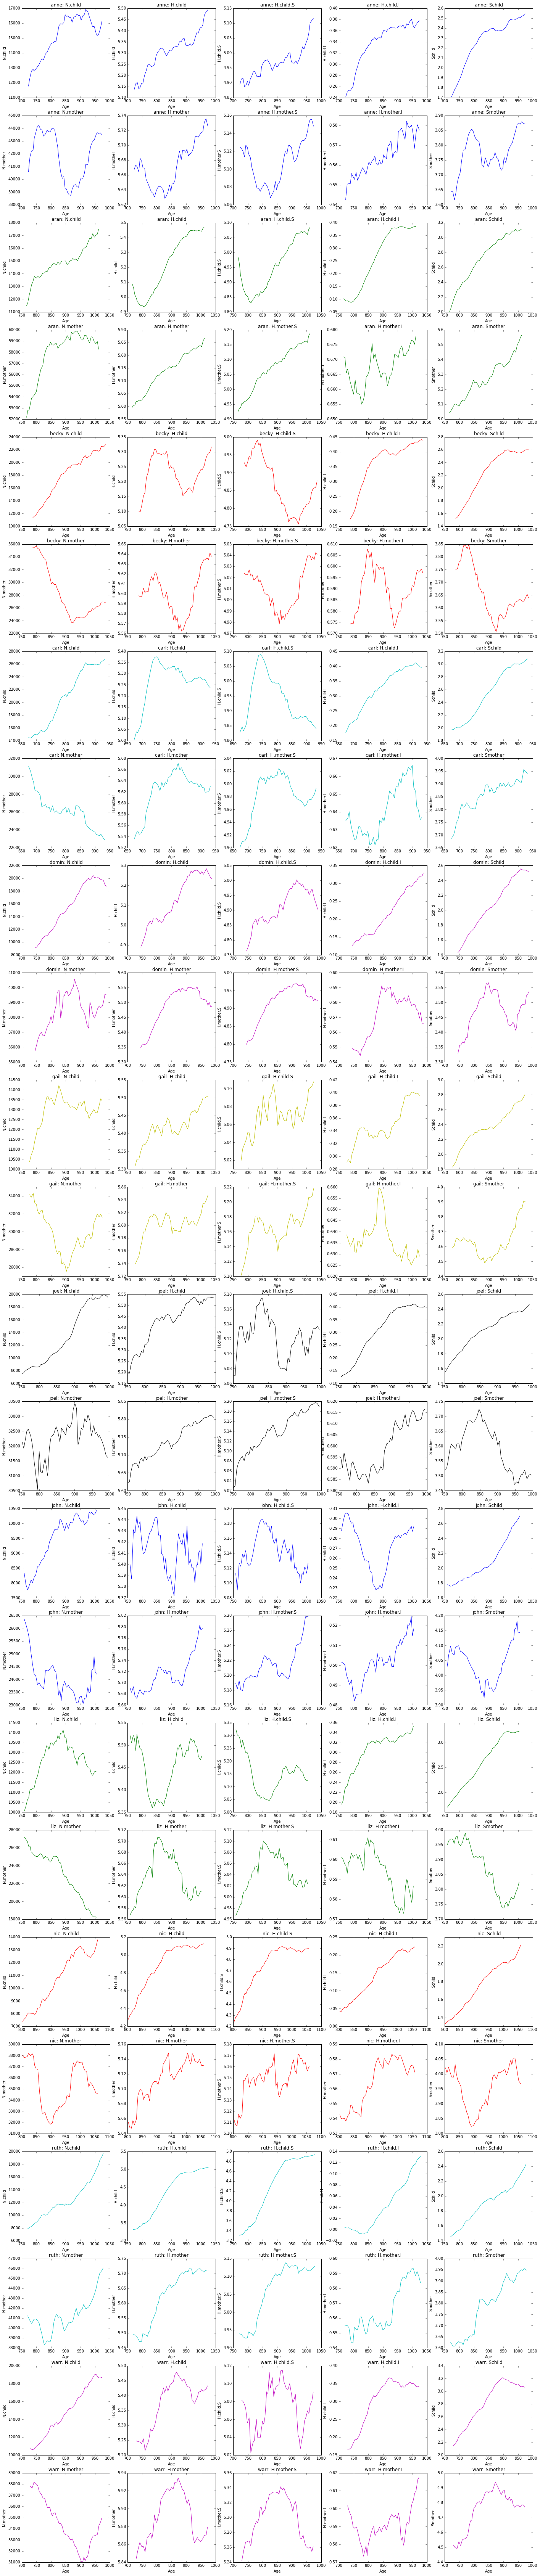

In [91]:
%matplotlib inline
from pandas import *
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Read data as a ssv (space-separated file)

df = pandas.read_csv(nmmfile, delimiter= ' ')

# Sort data by children alphabetically, then age increasing
sorted_df = df.sort(columns=['Child', 'Age'])

# sorted_df.to_csv("/Users/jeremyirvin/Desktop/SeniorThesis/Childes/nltk_childes/sorted-morph-eng.csv", sep = ' ');

# Get list of the names of the children
name_list = Series(sorted_df['Child']).unique()

# Sort the name list
sorted_name_list = sorted(name_list)

# Get list of the names of the columns
column_list = list(sorted_df.columns.values)

# Remove the column name 'Child' because it contains strings
column_list.remove('Child')

# Convert all other columns to floats
sorted_df[column_list] = sorted_df[column_list].astype(float)

# Create a list of data frames corresponding to each child
child_split_df = {}
for child in sorted_name_list:
    child_split_df[child] = sorted_df[sorted_df['Child'] == child]

# Plot the data nicely    
color_list = ['b','g','r','c','m','y','k'] 
    
# Define a function which plots a certain statistic for a certain child
def plot_stat(axarr, name, child_split_df, stat, row_num, column_num, color_num):
    axarr[row_num, column_num].plot((child_split_df[name])['Age'],  (child_split_df[name])[stat], linestyle = '-', color=color_list[color_num % 7])
    axarr[row_num, column_num].set_xlabel('Age')
    axarr[row_num, column_num].set_ylabel(stat)
    axarr[row_num, column_num].set_title(name + ": " + stat)

column_list.remove('Age')
name_num = 1

fig, axarr = plt.subplots(2 * len(name_list), len(column_list)/2)
fig.set_size_inches(24, 120)
row_num = 0
color_num = 0

for name in name_list:
    column_num = 0
    for stat in column_list:
        plot_stat(axarr, name, child_split_df, stat, row_num, column_num, color_num)
        column_num += 1
        if(column_num == len(column_list)/2):
            row_num += 1
            column_num = 0
    color_num += 1

plt.show()
# beaker.dict_child_df = child_split_df